# Multiple Linear Regression
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

## Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [618]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [619]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

Reusable Functions


In [620]:
def print_vif(df):
  # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
  vif = pd.DataFrame()
  vif['Features'] = df.columns
  vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [621]:
def build_model_print_statistics(X_train,y_train):
  #Build a linear model
  X_train_lm = sm.add_constant(X_train)
  model = sm.OLS(y_train, X_train_lm).fit()
  print(model.params)
  print(model.summary())
  return model,X_train_lm

Loading Data

In [622]:
bike = pd.read_csv("day.csv")

In [623]:
# Check the head of the dataset
bike.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

Inspect the various aspects of the housing dataframe

In [624]:
bike.shape
# Inference - 730 Rows, 16 Columns

(730, 16)

In [625]:
bike.info()
# Inference - no null values. Imputing not needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [626]:
bike.describe()
# Inference 
# - Scaling needed for  temp, atemp, him, windspeed
# - Should holiday and weekday be converted to categorical and then to dummy variables?

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

Drop unnecessary columns
- instant - just index
- dteday - yr and month are available in separate columns, so not needed
- casual, registered - total count given by cnt column makes more sense than the casual and registered columns.

In [627]:
columns = ['instant','dteday','casual','registered']
bike = bike.drop(columns, axis=1)
bike.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed   cnt  
0  18.18125  80.5833  10.749882   985  
1  17.68695  69.6087  16.652113   801  
2   9.47025  43.7273  16.636703  1349  
3  10.60610  59.0435  10.739832  1562  
4  11.46350  43.6957  12.522300  1600

Check for duplicates

In [628]:
bike_dup = bike.copy()

# Checking for duplicates and dropping the entire duplicate row if any
bike_dup.drop_duplicates(subset=None, inplace=True)
bike_dup.shape
# Inference
# - same value as original dataframe. So no duplicates.

(730, 12)

## Step 2: Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

In [629]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot numeric variables

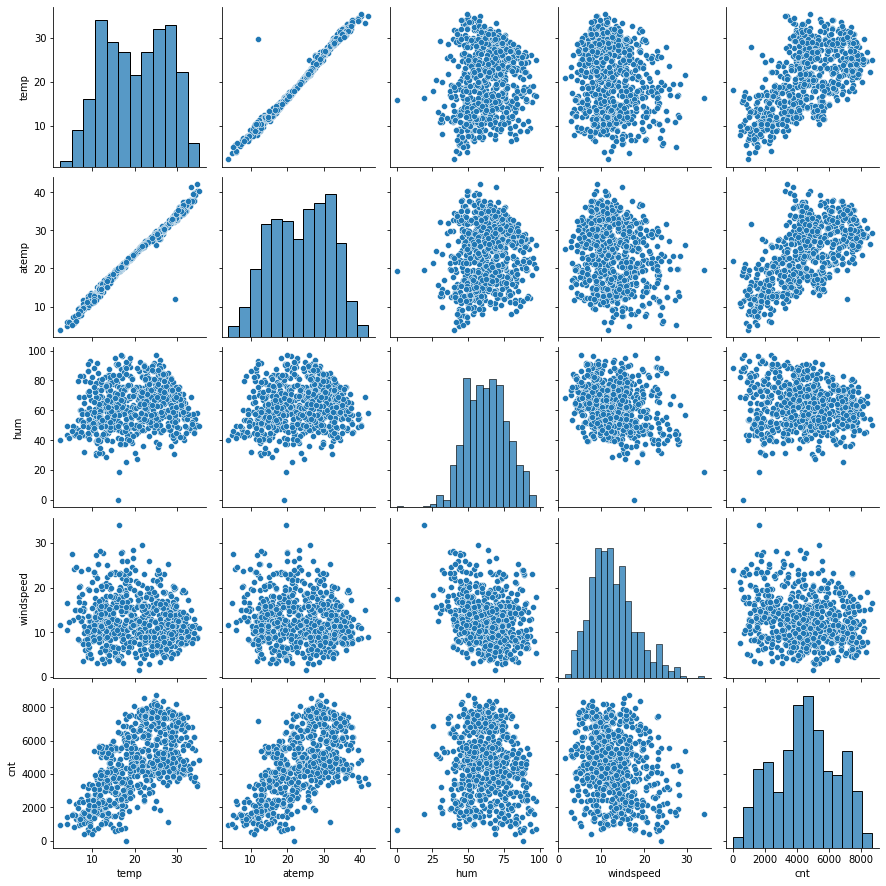

In [630]:
# pick only the relevant numeric variables and check
bike_num=bike[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]
sns.pairplot(bike_num)
plt.show()

Inference
- The pair plots tells us that there is a linear relationship between 
  - atemp and temp
  - atemp and cnt
  - temp and cnt

Plot categorical variables

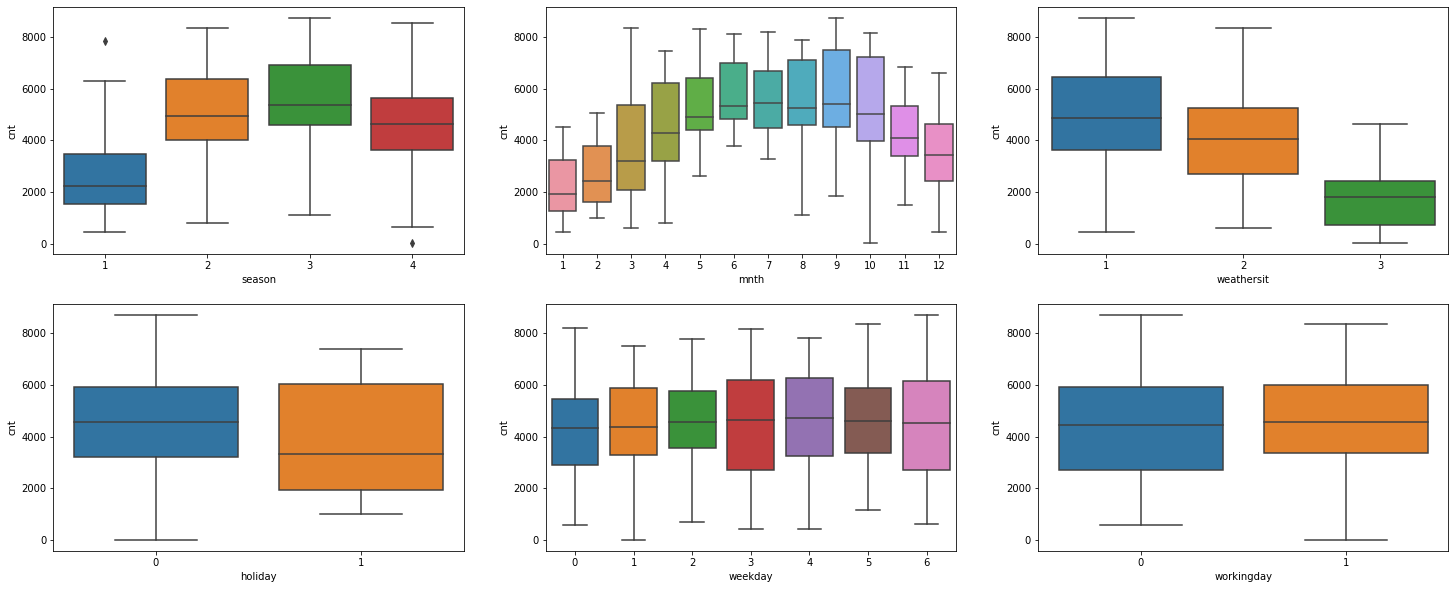

In [631]:
# Build boxplot of all categorical variables (before creating dummies) againt the target variable 'cnt' 

plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.show()

Inference
- Season
  - Season3 has the most bookings with highest median around 5000
  - It is clear that season affects the count. Hence it could be a predictor.
- Month
  - Mnth9 has the maximum bookings with a median of 5000
  - It is clear that mnth affects the count. Hence it could be a predictor.
- Weather situation
  - Weathersit1 has most bokkings with a median of 5000.
  - It is clear that Weathersit affects the count. Hence it could be a predictor.
- Holiday
  - when it is not a holiday, the median booking is higher. However, when it is a holiday, the 75th percentile is higher. Not sure. Will let the model decide if it is a good predictor.
- Weekday
  - Shows a pattern with median closely distributed.
  - Will let the model decide if it is a good predictor.
- Workingday
  - Workingday has higher median count than not a working day
  - It is clear that Workingday affects the count. Hence it could be a predictor.


Plot Correlation matrix

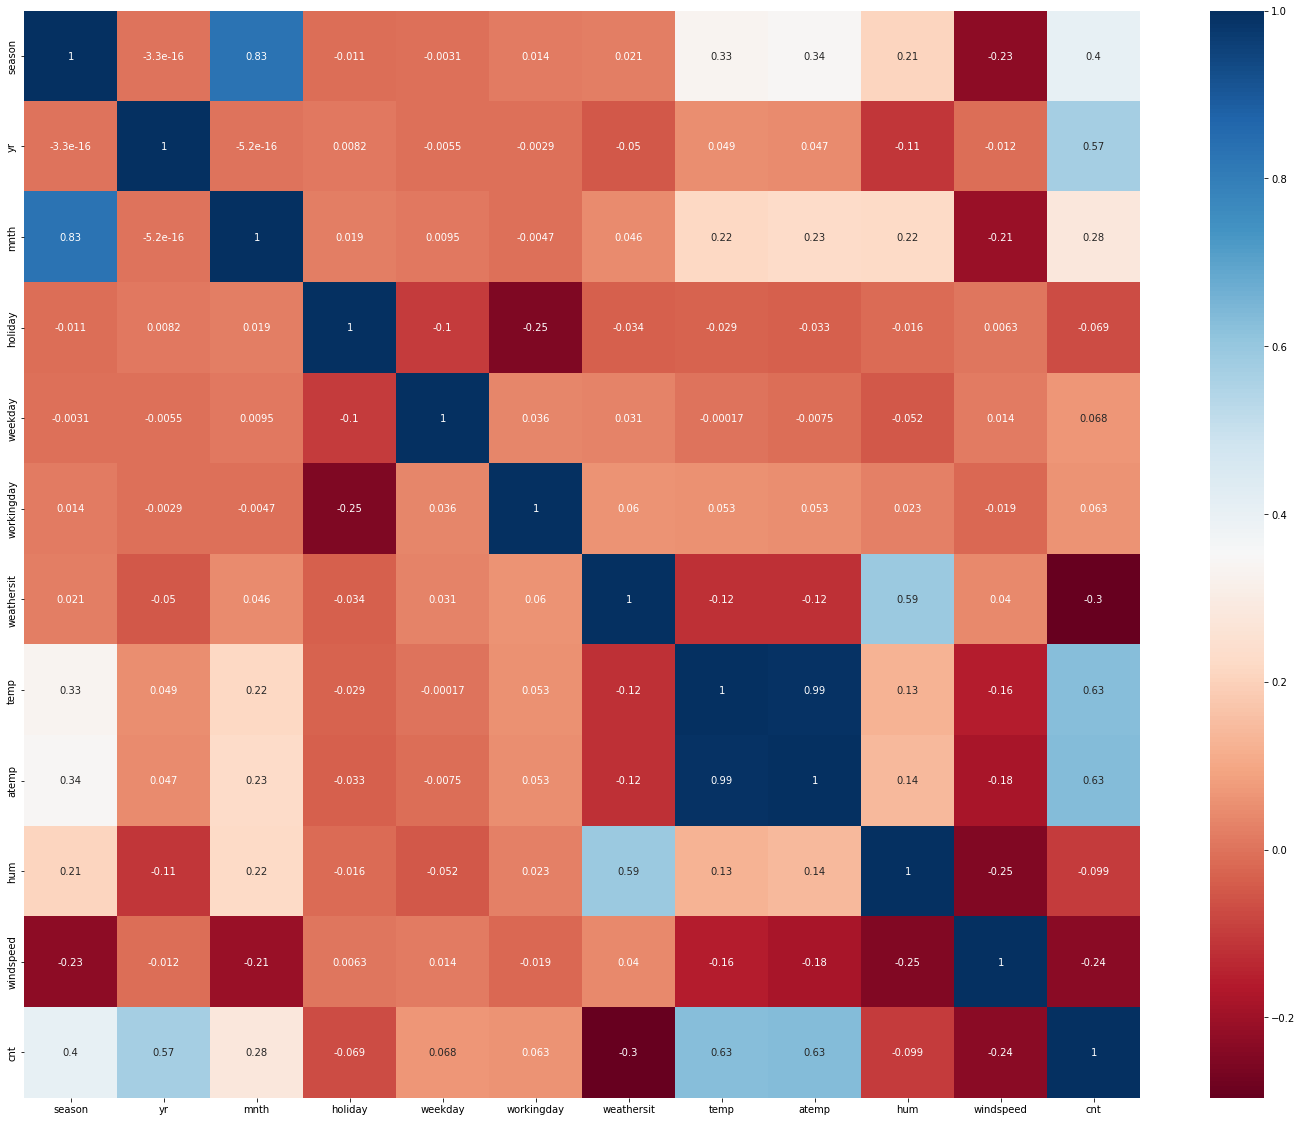

In [632]:
plt.figure(figsize = (25,20))
sns.heatmap(bike.corr(), annot = True, cmap="RdBu")
plt.show()

Inference 
- You can see high cor-relation between certain variables.
- cnt is most cor-related with temp, atemp, yr.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

## Step 3 - Data preparation and processing. 
Create dummy variables for categorical data
- Some columns like weathersit, season, month, weekday seem to be categorical but have int/float values

In [633]:
# check types
# Check the datatypes before conversion
bike.info()
# Inference
# mnth is int64
# weekday is int64
# weathersit is int64
# season is int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


Convert weathersit and season to categorical variables

In [634]:
# convert weathersit and season to actual string values from data dictionary
weathersit={1:'Clear',2:'Mist',3:'Light_Snow',4:'Heavy_Rain'}
season={1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
bike['weathersit']=bike['weathersit'].replace(weathersit)
bike['season']=bike['season'].replace(season)
bike.head()
bike.info()
# inference - type has changed to object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 68.6+ KB


Do Type Conversion of mnth and weekday

In [635]:
bike['mnth']=bike['mnth'].astype('category')
bike['weekday']=bike['weekday'].astype('category')
# check types
bike.info()
# inference - type has changed to category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    object  
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    category
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    object  
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(2), float64(4), int64(4), object(2)
memory usage: 59.3+ KB


Get dummies and remove source columns for weathersit, season, mnt, and weekday

In [636]:
bike = pd.get_dummies(bike, drop_first=True)
bike.info()
print(bike.shape)
# inference
# created dummies for categorical variables
# - # of columns increased to 30

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     730 non-null    int64  
 1   holiday                730 non-null    int64  
 2   workingday             730 non-null    int64  
 3   temp                   730 non-null    float64
 4   atemp                  730 non-null    float64
 5   hum                    730 non-null    float64
 6   windspeed              730 non-null    float64
 7   cnt                    730 non-null    int64  
 8   season_Spring          730 non-null    uint8  
 9   season_Summer          730 non-null    uint8  
 10  season_Winter          730 non-null    uint8  
 11  mnth_2                 730 non-null    uint8  
 12  mnth_3                 730 non-null    uint8  
 13  mnth_4                 730 non-null    uint8  
 14  mnth_5                 730 non-null    uint8  
 15  mnth_6

## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [637]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 42)
df_train.head()

yr  holiday  workingday       temp     atemp      hum  windspeed   cnt  \
683   1        0           1  13.188347  16.22460  62.0417  10.250129  5445   
645   1        1           0  15.716653  19.38040  70.9583  12.708493  5478   
163   0        0           1  26.035000  30.08270  49.4583  20.458450  5020   
360   0        0           1  13.325000  16.38165  76.2500  12.626150  1162   
640   1        0           1  26.957500  29.95665  79.3750   4.458569  7572   

     season_Spring  season_Summer  ...  mnth_11  mnth_12  weekday_1  \
683              0              0  ...        1        0          0   
645              0              0  ...        0        0          1   
163              0              1  ...        0        0          1   
360              1              0  ...        0        1          0   
640              0              0  ...        0        0          0   

     weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  \
683          0          0          1          0          0   
645          0          0          0          0          0   
163          0          0          0          0          0   
360          1          0          0          0          0   
640          0          1          0          0          0   

     weathersit_Light_Snow  weathersit_Mist  
683                      0                1  
645                      0                1  
163                      0                0  
360                      0                1  
640                      0                1  

[5 rows x 30 columns]

### Rescaling the Features 

We will use standardisation as it is not affected by outliers.
Also, Standardisation is preferred for linear regression.

In [638]:
scaler = StandardScaler()

In [639]:
# Apply scaler() to all the columns except the 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [640]:
df_train.head()

yr  holiday  workingday      temp     atemp       hum  windspeed  \
683   1        0           1 -0.985825 -0.960485 -0.100913  -0.471535   
645   1        1           0 -0.647592 -0.571424  0.539836   0.023926   
163   0        0           1  0.732778  0.748002 -1.005160   1.585859   
360   0        0           1 -0.967543 -0.941123  0.920100   0.007330   
640   1        0           1  0.856188  0.732462  1.144663  -1.638771   

          cnt  season_Spring  season_Summer  ...  mnth_11  mnth_12  weekday_1  \
683  0.458457              0              0  ...        1        0          0   
645  0.475507              0              0  ...        0        0          1   
163  0.238880              0              1  ...        0        0          1   
360 -1.754366              1              0  ...        0        1          0   
640  1.557377              0              0  ...        0        0          0   

     weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  \
683          0          0          1          0          0   
645          0          0          0          0          0   
163          0          0          0          0          0   
360          1          0          0          0          0   
640          0          1          0          0          0   

     weathersit_Light_Snow  weathersit_Mist  
683                      0                1  
645                      0                1  
163                      0                0  
360                      0                1  
640                      0                1  

[5 rows x 30 columns]

In [641]:
df_train.describe()

yr     holiday  workingday          temp         atemp  \
count  510.000000  510.000000  510.000000  5.100000e+02  5.100000e+02   
mean     0.521569    0.027451    0.668627  1.637035e-16 -2.089832e-17   
std      0.500025    0.163554    0.471169  1.000982e+00  1.000982e+00   
min      0.000000    0.000000    0.000000 -2.425813e+00 -2.473322e+00   
25%      0.000000    0.000000    0.000000 -8.667897e-01 -8.175615e-01   
50%      1.000000    0.000000    1.000000  1.088697e-01  1.797260e-01   
75%      1.000000    0.000000    1.000000  8.550460e-01  8.063589e-01   
max      1.000000    1.000000    1.000000  1.976025e+00  2.222742e+00   

                hum     windspeed           cnt  season_Spring  season_Summer  \
count  5.100000e+02  5.100000e+02  5.100000e+02     510.000000     510.000000   
mean   3.413392e-16 -1.828603e-16 -1.637035e-16       0.231373       0.256863   
std    1.000982e+00  1.000982e+00  1.000982e+00       0.422124       0.437332   
min   -4.559249e+00 -2.234995e+00 -2.132039e+00       0.000000       0.000000   
25%   -7.654631e-01 -7.150390e-01 -6.515709e-01       0.000000       0.000000   
50%    3.831603e-02 -1.649778e-01  1.723594e-02       0.000000       0.000000   
75%    7.179906e-01  5.991333e-01  7.654781e-01       0.000000       1.000000   
max    2.414198e+00  3.156177e+00  2.147395e+00       1.000000       1.000000   

       ...     mnth_11     mnth_12   weekday_1   weekday_2   weekday_3  \
count  ...  510.000000  510.000000  510.000000  510.000000  510.000000   
mean   ...    0.092157    0.074510    0.149020    0.131373    0.139216   
std    ...    0.289531    0.262857    0.356457    0.338139    0.346511   
min    ...    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    ...    0.000000    0.000000    0.000000    0.000000    0.000000   
50%    ...    0.000000    0.000000    0.000000    0.000000    0.000000   
75%    ...    0.000000    0.000000    0.000000    0.000000    0.000000   
max    ...    1.000000    1.000000    1.000000    1.000000    1.000000   

        weekday_4   weekday_5   weekday_6  weathersit_Light_Snow  \
count  510.000000  510.000000  510.000000             510.000000   
mean     0.147059    0.129412    0.150980               0.029412   
std      0.354512    0.335985    0.358381               0.169124   
min      0.000000    0.000000    0.000000               0.000000   
25%      0.000000    0.000000    0.000000               0.000000   
50%      0.000000    0.000000    0.000000               0.000000   
75%      0.000000    0.000000    0.000000               0.000000   
max      1.000000    1.000000    1.000000               1.000000   

       weathersit_Mist  
count       510.000000  
mean          0.345098  
std           0.475867  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000  

[8 rows x 30 columns]

### Dividing into X and Y sets for the model building

In [642]:
y_train = df_train.pop('cnt')
X_train = df_train

## Step 5: Building a linear model
### Model 1 - with all parameters using statsmodel


### Adding all the variables to the model

In [643]:
# Check all the columns of the dataframe
bike.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_Spring', 'season_Summer', 'season_Winter', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_Light_Snow',
       'weathersit_Mist'],
      dtype='object')

In [644]:
#Build a linear model
lr_1 = build_model_print_statistics(X_train,y_train)

const                   -0.517141
yr                       1.008491
holiday                 -0.154252
workingday               0.165930
temp                     0.180363
atemp                    0.250245
hum                     -0.100703
windspeed               -0.089508
season_Spring           -0.629935
season_Summer            0.047993
season_Winter            0.328755
mnth_2                   0.064481
mnth_3                   0.231481
mnth_4                  -0.009934
mnth_5                   0.126064
mnth_6                  -0.001221
mnth_7                  -0.186698
mnth_8                  -0.049068
mnth_9                   0.315064
mnth_10                  0.156097
mnth_11                 -0.226071
mnth_12                 -0.172048
weekday_1               -0.028388
weekday_2               -0.062636
weekday_3                0.019086
weekday_4                0.027267
weekday_5                0.056349
weekday_6                0.202008
weathersit_Light_Snow   -0.971599
weathersit_Mis

Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).

Maybe we could drop some?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information. 

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [645]:
print_vif(X_train)

                 Features     VIF
21              weekday_1     inf
2              workingday     inf
25              weekday_5     inf
24              weekday_4     inf
23              weekday_3     inf
22              weekday_2     inf
1                 holiday     inf
3                    temp  216.57
4                   atemp  201.57
8           season_Summer    9.20
9           season_Winter    8.62
7           season_Spring    5.40
13                 mnth_5    5.09
18                mnth_10    4.29
12                 mnth_4    4.16
19                mnth_11    4.14
14                 mnth_6    4.03
15                 mnth_7    2.79
28        weathersit_Mist    2.48
20                mnth_12    2.31
16                 mnth_8    2.18
0                      yr    2.15
17                 mnth_9    2.11
5                     hum    2.04
26              weekday_6    1.89
11                 mnth_3    1.87
10                 mnth_2    1.76
27  weathersit_Light_Snow    1.40
6             

We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

An infinite VIF value indicates that the corresponding variable may be expressed exactly by a linear combination of other variables.

Dropping weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, workingday, holiday

### Dropping the variable and updating the model

In [646]:
# Dropping highly correlated variables and insignificant variables
X = X_train.drop(['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'workingday', 'holiday'], 1)

In [647]:
# Build a second fitted model
lr_2 = build_model_print_statistics(X,y_train)

const                   -0.342163
yr                       1.006272
temp                     0.113503
atemp                    0.330095
hum                     -0.109678
windspeed               -0.091444
season_Spring           -0.679554
season_Summer            0.024487
season_Winter            0.332485
mnth_2                   0.064748
mnth_3                   0.235720
mnth_4                  -0.048084
mnth_5                   0.099624
mnth_6                  -0.033491
mnth_7                  -0.256954
mnth_8                  -0.091880
mnth_9                   0.261613
mnth_10                  0.090775
mnth_11                 -0.278063
mnth_12                 -0.211097
weekday_6                0.076488
weathersit_Light_Snow   -0.925412
weathersit_Mist         -0.235688
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. 

In [648]:
# Calculate the VIFs again for the new model
print_vif(X)

                 Features     VIF
1                    temp  210.26
2                   atemp  195.87
6           season_Summer    9.08
7           season_Winter    8.43
11                 mnth_5    4.83
5           season_Spring    4.77
16                mnth_10    4.10
10                 mnth_4    3.98
17                mnth_11    3.94
12                 mnth_6    3.71
21        weathersit_Mist    2.46
13                 mnth_7    2.39
18                mnth_12    2.23
0                      yr    2.14
3                     hum    1.98
9                  mnth_3    1.81
14                 mnth_8    1.80
15                 mnth_9    1.77
8                  mnth_2    1.74
20  weathersit_Light_Snow    1.38
4               windspeed    1.37
19              weekday_6    1.20


### Dropping the Variables and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

- temp has high VIF and high p-value. However, from the business point of view temperature would be an important predictor. Based on domain knowledge not dropping temp yet.
- Removing the variable 'atemp' based on its High p-value & High VIF



In [649]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('atemp', 1)

In [650]:
# Build a second fitted model
lr_3 = build_model_print_statistics(X,y_train)

const                   -0.332877
yr                       1.005081
temp                     0.451021
hum                     -0.107386
windspeed               -0.099808
season_Spring           -0.683376
season_Summer            0.030502
season_Winter            0.333899
mnth_2                   0.071562
mnth_3                   0.240578
mnth_4                  -0.043357
mnth_5                   0.086556
mnth_6                  -0.065243
mnth_7                  -0.280846
mnth_8                  -0.122974
mnth_9                   0.241167
mnth_10                  0.092563
mnth_11                 -0.272010
mnth_12                 -0.202695
weekday_6                0.076957
weathersit_Light_Snow   -0.947295
weathersit_Mist         -0.239804
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833


In [651]:
# Calculate the VIFs again for the new model
print_vif(X)

                 Features   VIF
5           season_Summer  9.04
6           season_Winter  8.42
1                    temp  6.41
10                 mnth_5  4.82
4           season_Spring  4.77
15                mnth_10  4.09
9                  mnth_4  3.97
16                mnth_11  3.92
11                 mnth_6  3.62
20        weathersit_Mist  2.45
12                 mnth_7  2.35
17                mnth_12  2.21
0                      yr  2.13
2                     hum  1.98
8                  mnth_3  1.80
14                 mnth_9  1.75
13                 mnth_8  1.74
7                  mnth_2  1.73
19  weathersit_Light_Snow  1.35
3               windspeed  1.24
18              weekday_6  1.20


### Inference
- temp VIF value has dropped.
- season_Summer has high VIF and high p-value. Should this be dropped? Doesnt make sense to drop this as it is of business value.
- season_Winter has high VIF and low p-value. So not dropping this column yet.
- temp is important for business as well
- The other predictors have low VIF values.
- The Adj. R- squared is 83%. 
- Keeping this model (lr_3) for now.

## Model 2 - building model using RFE

In [652]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm, n_features_to_select=15)  # running RFE
rfe = rfe.fit(X_train, y_train)

In [653]:
# print RFE results
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

# Difference from manual elimination
# RFE is removing temp, season_Summer
# RFE is keeping weekday and holiday.

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', False, 3),
 ('atemp', True, 1),
 ('hum', False, 4),
 ('windspeed', False, 5),
 ('season_Spring', True, 1),
 ('season_Summer', False, 10),
 ('season_Winter', True, 1),
 ('mnth_2', False, 9),
 ('mnth_3', True, 1),
 ('mnth_4', False, 14),
 ('mnth_5', True, 1),
 ('mnth_6', False, 15),
 ('mnth_7', True, 1),
 ('mnth_8', False, 6),
 ('mnth_9', True, 1),
 ('mnth_10', False, 2),
 ('mnth_11', True, 1),
 ('mnth_12', True, 1),
 ('weekday_1', False, 8),
 ('weekday_2', False, 7),
 ('weekday_3', False, 13),
 ('weekday_4', False, 12),
 ('weekday_5', False, 11),
 ('weekday_6', True, 1),
 ('weathersit_Light_Snow', True, 1),
 ('weathersit_Mist', True, 1)]

In [654]:
# print only columns that RFE selewcted
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'atemp', 'season_Spring',
       'season_Winter', 'mnth_3', 'mnth_5', 'mnth_7', 'mnth_9', 'mnth_11',
       'mnth_12', 'weekday_6', 'weathersit_Light_Snow', 'weathersit_Mist'],
      dtype='object')

In [655]:
# print columns not selected by RFE
X_train.columns[~rfe.support_]

Index(['temp', 'hum', 'windspeed', 'season_Summer', 'mnth_2', 'mnth_4',
       'mnth_6', 'mnth_8', 'mnth_10', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5'],
      dtype='object')

In [656]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

#### Building model using statsmodel for detailed statistics

In [657]:
print_vif(X_train_rfe)

                 Features   VIF
4           season_Spring  3.19
3                   atemp  3.18
2              workingday  3.01
5           season_Winter  2.65
0                      yr  1.96
10                mnth_11  1.88
14        weathersit_Mist  1.54
8                  mnth_7  1.51
12              weekday_6  1.39
11                mnth_12  1.37
7                  mnth_5  1.26
9                  mnth_9  1.24
6                  mnth_3  1.19
1                 holiday  1.10
13  weathersit_Light_Snow  1.09


In [658]:
lr_rfe_1 = build_model_print_statistics(X_train_rfe,y_train)

const                   -0.469312
yr                       1.032464
holiday                 -0.139127
workingday               0.185570
atemp                    0.411823
season_Spring           -0.638242
season_Winter            0.420374
mnth_3                   0.243902
mnth_5                   0.123259
mnth_7                  -0.167739
mnth_9                   0.259751
mnth_11                 -0.355185
mnth_12                 -0.268492
weekday_6                0.213755
weathersit_Light_Snow   -1.218429
weathersit_Mist         -0.363990
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     168.3
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          4.81e-183
Time:                        07:14:15   Log-Li

In [659]:
### Inference
# - There are no predictors with high VIF values.
# - There are no predictors with high p-value.
# - The Adj R squared value is 83%.
# This is as good as lr_3 model created by manual elimination.

## Building model with a combination of RFE and manual elimination

In [660]:
# print only columns that RFE selewcted
# type(rfe.support_)
col = X_train.columns[rfe.support_,]
# Creating X_test dataframe with RFE selected variables
X_train_hybrid = X_train[col]
X_train_hybrid.head()

yr  holiday  workingday     atemp  season_Spring  season_Winter  mnth_3  \
683   1        0           1 -0.960485              0              1       0   
645   1        1           0 -0.571424              0              1       0   
163   0        0           1  0.748002              0              0       0   
360   0        0           1 -0.941123              1              0       0   
640   1        0           1  0.732462              0              1       0   

     mnth_5  mnth_7  mnth_9  mnth_11  mnth_12  weekday_6  \
683       0       0       0        1        0          0   
645       0       0       0        0        0          0   
163       0       0       0        0        0          0   
360       0       0       0        0        1          0   
640       0       0       0        0        0          0   

     weathersit_Light_Snow  weathersit_Mist  
683                      0                1  
645                      0                1  
163                      0                0  
360                      0                1  
640                      0                1

In [661]:
# adding temp and season_summer to dataframe as they make sense from business
X_train_hybrid['temp']=X_train['temp']
X_train_hybrid.head()

yr  holiday  workingday     atemp  season_Spring  season_Winter  mnth_3  \
683   1        0           1 -0.960485              0              1       0   
645   1        1           0 -0.571424              0              1       0   
163   0        0           1  0.748002              0              0       0   
360   0        0           1 -0.941123              1              0       0   
640   1        0           1  0.732462              0              1       0   

     mnth_5  mnth_7  mnth_9  mnth_11  mnth_12  weekday_6  \
683       0       0       0        1        0          0   
645       0       0       0        0        0          0   
163       0       0       0        0        0          0   
360       0       0       0        0        1          0   
640       0       0       0        0        0          0   

     weathersit_Light_Snow  weathersit_Mist      temp  
683                      0                1 -0.985825  
645                      0                1 -0.647592  
163                      0                0  0.732778  
360                      0                1 -0.967543  
640                      0                1  0.856188

In [662]:
print_vif(X_train_hybrid)

                 Features     VIF
15                   temp  161.94
3                   atemp  160.14
4           season_Spring    3.19
2              workingday    3.01
5           season_Winter    2.73
0                      yr    1.96
10                mnth_11    1.88
14        weathersit_Mist    1.55
8                  mnth_7    1.51
12              weekday_6    1.40
11                mnth_12    1.38
7                  mnth_5    1.26
9                  mnth_9    1.24
6                  mnth_3    1.20
1                 holiday    1.11
13  weathersit_Light_Snow    1.11


In [663]:
# Dropping highly correlated variables and insignificant variables
X_train_hybrid = X_train_hybrid.drop('atemp', 1)
print_vif(X_train_hybrid)

                 Features   VIF
14                   temp  3.22
3           season_Spring  3.18
2              workingday  3.01
4           season_Winter  2.68
0                      yr  1.96
9                 mnth_11  1.88
13        weathersit_Mist  1.54
7                  mnth_7  1.51
11              weekday_6  1.40
10                mnth_12  1.38
6                  mnth_5  1.25
8                  mnth_9  1.24
5                  mnth_3  1.19
1                 holiday  1.11
12  weathersit_Light_Snow  1.08


In [664]:
lr_hyb_1,X_train_lm = build_model_print_statistics(X_train_hybrid,y_train)

const                   -0.472997
yr                       1.031635
holiday                 -0.147355
workingday               0.188127
season_Spring           -0.645333
season_Winter            0.436148
mnth_3                   0.257785
mnth_5                   0.133958
mnth_7                  -0.166137
mnth_9                   0.255425
mnth_11                 -0.356777
mnth_12                 -0.261011
weekday_6                0.214449
weathersit_Light_Snow   -1.248059
weathersit_Mist         -0.366724
temp                     0.409431
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     166.7
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          3.46e-182
Time:                        07:14:15   Log-Li

#### Inference
- The adjusted R Squared is 83%
- The p-value of holiday, month_5, month_7 is high. So removing it.

In [666]:
# dropping holiday,'mnth_5','mnth_7'
X_train_hybrid = X_train_hybrid.drop(['holiday','mnth_5','mnth_7'], 1)
print_vif(X_train_hybrid)

                 Features   VIF
2           season_Spring  2.89
1              workingday  2.65
3           season_Winter  2.58
11                   temp  2.56
0                      yr  1.91
6                 mnth_11  1.85
10        weathersit_Mist  1.52
7                 mnth_12  1.37
8               weekday_6  1.33
4                  mnth_3  1.17
5                  mnth_9  1.16
9   weathersit_Light_Snow  1.08


In [667]:
lr_hyb_2,X_train_lm = build_model_print_statistics(X_train_hybrid,y_train)

const                   -0.485005
yr                       1.029941
workingday               0.219847
season_Spring           -0.705993
season_Winter            0.414653
mnth_3                   0.258064
mnth_9                   0.266382
mnth_11                 -0.382346
mnth_12                 -0.281859
weekday_6                0.241294
weathersit_Light_Snow   -1.264721
weathersit_Mist         -0.356747
temp                     0.372932
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     203.5
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          5.51e-183
Time:                        07:16:01   Log-Likelihood:                -270.51
No. Observations:                 510   AIC:                         

## Step 7: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [668]:
y_train_cnt = lr_hyb_2.predict(X_train_lm)

Text(0.5, 0, 'Errors')

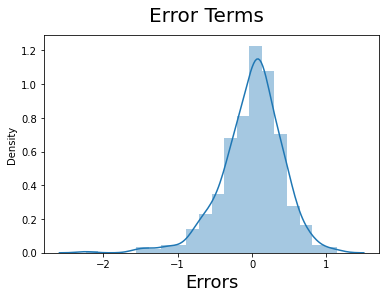

In [669]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Inference:
- Error terms are normally distributed.

## Step 8: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

#### Applying the scaling on the test sets

In [670]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [671]:
df_test.describe()

yr     holiday  workingday        temp       atemp         hum  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.452055    0.031963    0.716895   -0.103986   -0.117026   -0.169141   
std      0.498836    0.176306    0.451539    1.012141    1.013217    1.064040   
min      0.000000    0.000000    0.000000   -2.215956   -2.233778   -3.208872   
25%      0.000000    0.000000    0.000000   -0.999537   -0.995498   -0.929718   
50%      0.000000    0.000000    1.000000   -0.190513   -0.143393   -0.316494   
75%      1.000000    0.000000    1.000000    0.771627    0.743613    0.572515   
max      1.000000    1.000000    1.000000    1.848040    1.938775    2.429166   

        windspeed         cnt  season_Spring  season_Summer  ...     mnth_11  \
count  219.000000  219.000000     219.000000     219.000000  ...  219.000000   
mean     0.112920   -0.079824       0.283105       0.237443  ...    0.059361   
std      1.146972    0.997498       0.451539       0.426491  ...    0.236840   
min     -1.907429   -2.343350       0.000000       0.000000  ...    0.000000   
25%     -0.719232   -0.908864       0.000000       0.000000  ...    0.000000   
50%      0.012583   -0.115544       0.000000       0.000000  ...    0.000000   
75%      0.645446    0.624561       1.000000       0.000000  ...    0.000000   
max      4.315039    2.065247       1.000000       1.000000  ...    1.000000   

          mnth_12   weekday_1   weekday_2   weekday_3   weekday_4   weekday_5  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.109589    0.132420    0.168950    0.141553    0.132420    0.173516   
std      0.313092    0.339723    0.375566    0.349389    0.339723    0.379560   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        weekday_6  weathersit_Light_Snow  weathersit_Mist  
count  219.000000             219.000000       219.000000  
mean     0.127854               0.027397         0.315068  
std      0.334692               0.163612         0.465607  
min      0.000000               0.000000         0.000000  
25%      0.000000               0.000000         0.000000  
50%      0.000000               0.000000         0.000000  
75%      0.000000               0.000000         1.000000  
max      1.000000               1.000000         1.000000  

[8 rows x 30 columns]

#### Dividing into X_test and y_test

In [672]:
y_test = df_test.pop('cnt')
X_test = df_test

In [673]:
# Adding constant variable to test dataframe
X_test_hyb = sm.add_constant(X_test)
# dropping unnecessary columns
X_test_new= X_test_hyb[X_train_lm.columns]
X_test_new.head()


const  yr  workingday  season_Spring  season_Winter  mnth_3  mnth_9  \
468    1.0   1           0              0              0       0       0   
148    1.0   0           0              0              0       0       0   
302    1.0   0           0              0              1       0       0   
355    1.0   0           1              1              0       0       0   
515    1.0   1           1              0              0       0       0   

     mnth_11  mnth_12  weekday_6  weathersit_Light_Snow  weathersit_Mist  \
468        0        0          1                      0                0   
148        0        0          0                      0                0   
302        0        0          0                      0                0   
355        0        1          0                      0                1   
515        0        0          0                      0                0   

         temp  
468 -0.035109  
148  0.911037  
302 -0.999537  
355 -0.428196  
515  0.979599

In [674]:
X_test_new.columns

Index(['const', 'yr', 'workingday', 'season_Spring', 'season_Winter', 'mnth_3',
       'mnth_9', 'mnth_11', 'mnth_12', 'weekday_6', 'weathersit_Light_Snow',
       'weathersit_Mist', 'temp'],
      dtype='object')

In [675]:
# Making predictions using the hybrid model
y_pred_hyb = lr_hyb_2.predict(X_test_new)

## Step 9: Model Evaluation

Let's now plot the graph for actual versus predicted values.

const                   -0.485005
yr                       1.029941
workingday               0.219847
season_Spring           -0.705993
season_Winter            0.414653
mnth_3                   0.258064
mnth_9                   0.266382
mnth_11                 -0.382346
mnth_12                 -0.281859
weekday_6                0.241294
weathersit_Light_Snow   -1.264721
weathersit_Mist         -0.356747
temp                     0.372932
dtype: float64

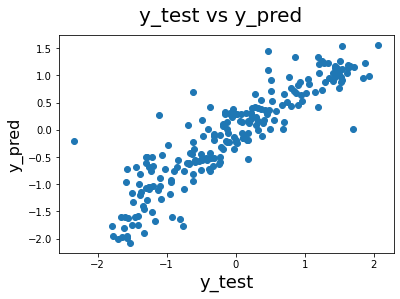

In [676]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred_hyb)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  

In [677]:
lr_hyb_2.params 

const                   -0.485005
yr                       1.029941
workingday               0.219847
season_Spring           -0.705993
season_Winter            0.414653
mnth_3                   0.258064
mnth_9                   0.266382
mnth_11                 -0.382346
mnth_12                 -0.281859
weekday_6                0.241294
weathersit_Light_Snow   -1.264721
weathersit_Mist         -0.356747
temp                     0.372932
dtype: float64


We can see that the equation of our best fitted line is:

cnt = - 0.485 + 1.029 * yr + 0.219 * workingday - 0.70 * season_Spring + 0.414 * season_Winter + 0.258 * mnth_3 + 0.266 * mnth_9 - 0.382 * mnth_11 - 0.281 * mnth_12 + 0.241 * weekday_6 - 1.264 * weathersit_Light_Snow - 0.356 * weathersit_Mist + 0.372 * temp


### Interpretation of Co-efficients
- yr
  - A coefficient value of ‘1.029’ indicated that a unit increase in yr variable, increases the bike hire numbers by 1.029 units.
- workingday
  - A coefficient value of ‘0.219’ indicated that, a unit increase in workingday variable increases the bike hire numbers by 0.219 units.
- season_Spring
  - A coefficient value of ‘- 0.70’ indicated that w.r.t season_Fall, a unit increase in season_Spring variable decreases the bike hire numbers by 0.70 units.
- season_Winter
  - A coefficient value of ‘0.414’ indicated that w.r.t season_Fall, a unit increase in season_Spring variable increases the bike hire numbers by 0.414 units.
- mnth_3
  -  A coefficient value of ‘0.258’ indicated that w.r.t mnth_1, a unit increase in mnth_3 variable increases the bike hire numbers by 0.258 units.
- mnth_9
  - A coefficient value of ‘0.266’ indicated that w.r.t mnth_1, a unit increase in mnth_9 variable increases the bike hire numbers by 0.266 units.
- mnth_11
  - A coefficient value of ‘- 0.382’ indicated that w.r.t mnth_1, a unit increase in mnth_9 variable decreases the bike hire numbers by 0.382 units.
- mnth_12
- weekday_6
- weathersit_Light_Snow
- weathersit_Mist
- temp


temp: A coefficient value of ‘0.5636’ indicated that a unit increase in temp variable, increases the bike hire numbers by 0.5636 units.

weathersit_3: A coefficient value of ‘-0.3070’ indicated that, w.r.t Weathersit1, a unit increase in Weathersit3 variable, decreases the bike hire numbers by 0.3070 units.

season_4: A coefficient value of ‘0.128744’ indicated that w.r.t season_1, a unit increase in season_4 variable increases the bike hire numbers by 0.128744 units.

windspeed: A coefficient value of ‘-0.155191’ indicated that, a unit increase in windspeed variable decreases the bike hire numbers by 0.155191 units.

workingday: A coefficient value of ‘0.043203’ indicated that, a unit increase in workingday variable increases the bike hire numbers by 0.043203 units.

season_2: A coefficient value of ‘0.082706’ indicated that w.r.t season_1, a unit increase in season_2 variable decreases the bike hire numbers by 0.082706 units.

mnth_9: A coefficient value of ‘0.094743’ indicated that w.r.t mnth_1, a unit increase in mnth_9 variable increases the bike hire numbers by 0.094743 units.

weekday_6: A coefficient value of ‘0.056909’ indicated that w.r.t weekday_1, a unit increase in weekday_6 variable increases the bike hire numbers by 0.056909 units.

weathersit_2: A coefficient value of ‘-0.074807’ indicated that, w.r.t Weathersit1, a unit increase in Weathersit2 variable, decreases the bike hire numbers by 0.074807 units.

const: The Constant value of ‘0.084143’ indicated that, in the absence of all other predictor variables (i.e. when x1,x2...xn =0), The bike rental can still increase by 0.084143 units.



Overall we have a decent model, but we could do better.